In [ ]:
import sqlite3
import csv

conn = sqlite3.connect("sqlite.db")
cursor = conn.cursor()

In [ ]:
# Create table
cursor.execute("""
CREATE TABLE IF NOT EXISTS sales (
    Item_Fat_Content TEXT,
    Item_Identifier TEXT,
    Item_Type TEXT,
    Outlet_Establishment_Year INTEGER,
    Outlet_Identifier TEXT,
    Outlet_Location_Type TEXT,
    Outlet_Size TEXT,
    Outlet_Type TEXT,
    Item_Visibility REAL,
    Item_Weight REAL,
    Sales REAL,
    Rating REAL
)
""")

def to_float(val):
    return float(val) if val.strip() else None  # or 0.0 if you prefer

def to_int(val):
    return int(val) if val.strip() else None  # or 0

with open("./blinkit_grocery_data.csv", newline='', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    rows = [
        (
            row["Item Fat Content"],
            row["Item Identifier"],
            row["Item Type"],
            to_int(row["Outlet Establishment Year"]),
            row["Outlet Identifier"],
            row["Outlet Location Type"],
            row["Outlet Size"],
            row["Outlet Type"],
            to_float(row["Item Visibility"]),
            to_float(row["Item Weight"]),
            to_float(row["Sales"]),
            to_float(row["Rating"])
        )
        for row in reader
    ]


cursor.executemany("""
INSERT INTO sales VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""", rows)

# Commit
conn.commit()

print("CSV data imported into SQLite database successfully.")


CSV data imported into SQLite database successfully.


In [ ]:
cursor.execute("SELECT item_identifier, item_weight, count(item_weight) FROM sales GROUP BY item_identifier, item_weight LIMIT 10")
rows = cursor.fetchall()
for row in rows:
    print(row)



('DRA12', 11.6, 6)
('DRA24', None, 0)
('DRA24', 19.35, 5)
('DRA59', None, 0)
('DRA59', 8.27, 6)
('DRB01', None, 0)
('DRB01', 7.39, 2)
('DRB13', 6.115, 5)
('DRB24', 8.785, 4)
('DRB25', None, 0)


In [7]:
# Update item_weight for NULL values
cursor.execute("""
UPDATE sales
SET item_weight = (
    SELECT DISTINCT a.item_weight
    FROM sales a
    WHERE a.item_identifier = sales.item_identifier
    AND a.item_weight IS NOT NULL
)
WHERE item_weight IS NULL
""")
conn.commit()


In [8]:
cursor.execute("UPDATE sales SET item_fat_content = 'Low Fat' WHERE item_fat_content = 'LF'")
cursor.execute("UPDATE sales SET item_fat_content = 'Low Fat' WHERE item_fat_content = 'low fat'")
cursor.execute("UPDATE sales SET item_fat_content = 'Regular' WHERE item_fat_content = 'reg'")
conn.commit()


In [ ]:
cursor.execute("""SELECT a.item_identifier, 
               a.item_fat_content, 
               a.item_type, 
               a.item_weight, 
               count(a.item_identifier) 
               FROM 
               (SELECT DISTINCT item_identifier, 
               item_fat_content, 
               item_type, 
               item_weight 
               FROM sales) a 
               GROUP BY a.item_identifier 
               HAVING count(a.item_identifier) > 1""")

rows = cursor.fetchall()
for row in rows:
    print(row)

In [10]:
# create an item table with item_identifier, item_fat_content, item_type, item_weight
cursor.execute("""
CREATE TABLE IF NOT EXISTS items (
    item_identifier TEXT PRIMARY KEY,
    item_fat_content TEXT,
    item_type TEXT,
    item_weight REAL
)
""")

# insert data into items table
cursor.execute("""
INSERT INTO items (item_identifier, item_fat_content, item_type, item_weight)
SELECT DISTINCT item_identifier, item_fat_content, item_type, item_weight FROM sales
""")
conn.commit()

In [ ]:
# create an outlet table with outlet_identifier, outlet_establishment_year, outlet_location_type, outlet_size, outlet_type
cursor.execute("""
CREATE TABLE IF NOT EXISTS outlets (
    outlet_identifier TEXT PRIMARY KEY,
    outlet_establishment_year INTEGER,
    outlet_location_type TEXT,
    outlet_type TEXT
)
""")

# insert data into outlets table
cursor.execute("""
INSERT INTO outlets (outlet_identifier, outlet_establishment_year, outlet_location_type, outlet_type)
SELECT DISTINCT outlet_identifier, outlet_establishment_year, outlet_location_type, outlet_type FROM sales
""")
conn.commit()

In [ ]:
# create a sales table with item_identifier, outlet_identifier, item_visibility, sales, rating
cursor.execute("""
CREATE TABLE sales_new AS
SELECT 
    item_identifier,
    outlet_identifier,
    outlet_size,
    item_visibility,
    sales,
    rating
FROM sales
""")

cursor.execute("DROP TABLE sales")

cursor.execute("ALTER TABLE sales_new RENAME TO sales")

conn.commit()


In [11]:
conn.close()

Dataset loaded successfully.

--- Initial Data Inspection ---

First 5 Rows:
  Item Fat Content Item Identifier              Item Type  \
0          Regular           FDX32  Fruits and Vegetables   
1          Low Fat           NCB42     Health and Hygiene   
2          Regular           FDR28           Frozen Foods   
3          Regular           FDL50                 Canned   
4          Low Fat           DRI25            Soft Drinks   

   Outlet Establishment Year Outlet Identifier Outlet Location Type  \
0                       2012            OUT049               Tier 1   
1                       2022            OUT018               Tier 3   
2                       2016            OUT046               Tier 1   
3                       2014            OUT013               Tier 3   
4                       2015            OUT045               Tier 2   

  Outlet Size        Outlet Type  Item Visibility  Item Weight     Sales  \
0      Medium  Supermarket Type1         0.100014    

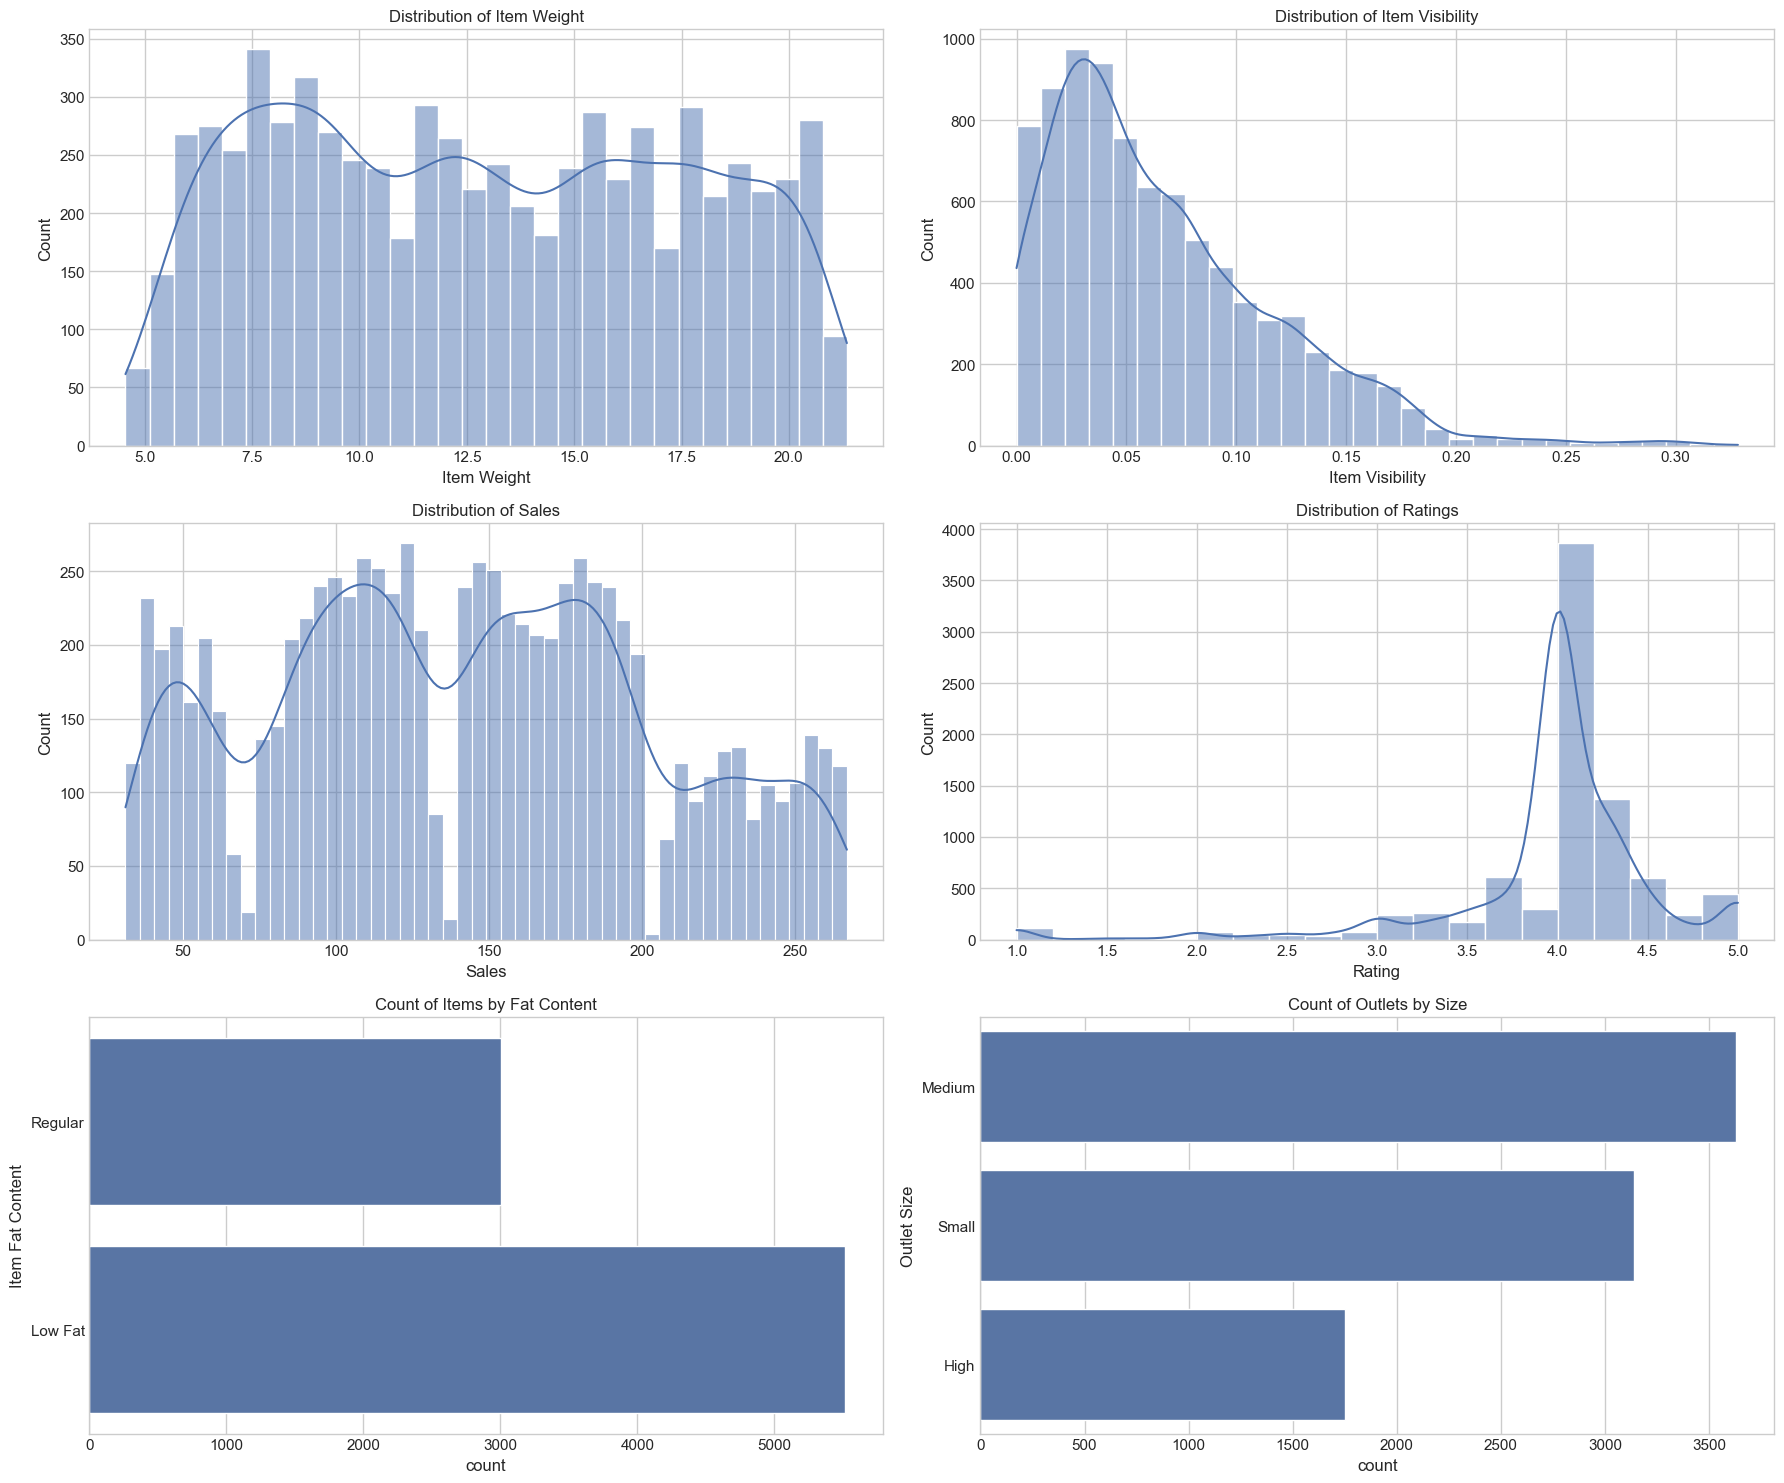

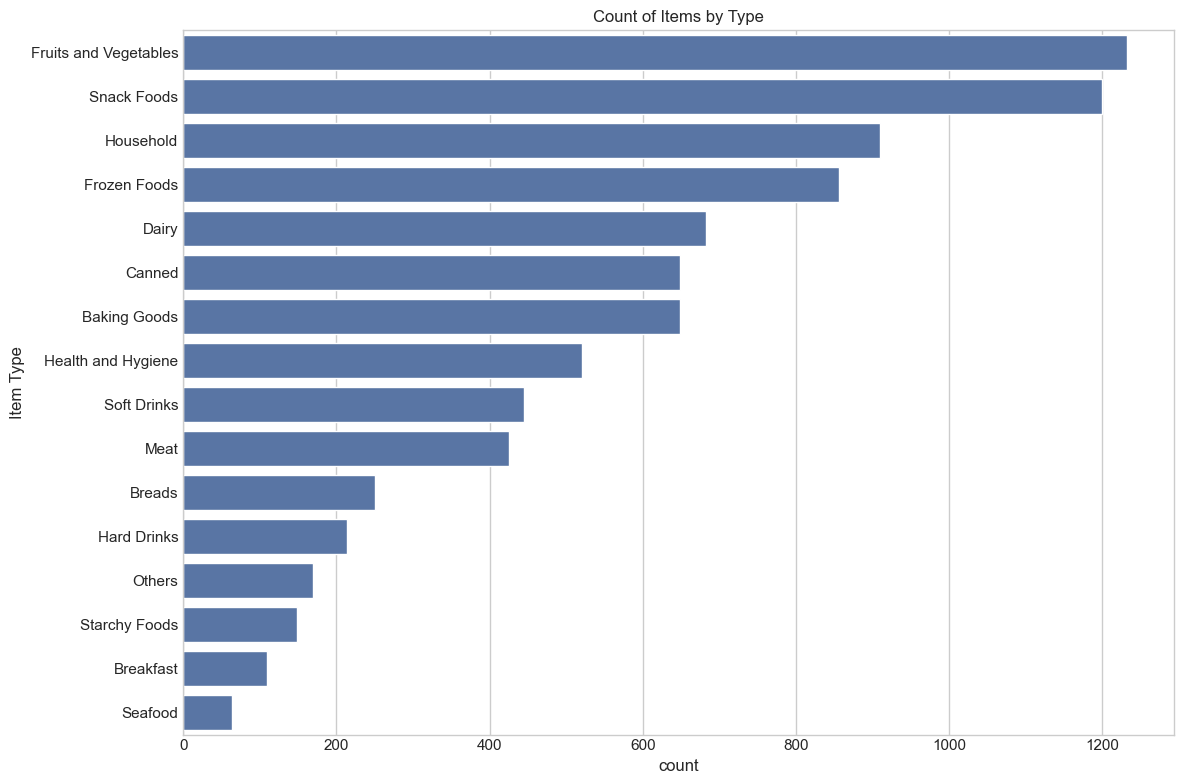

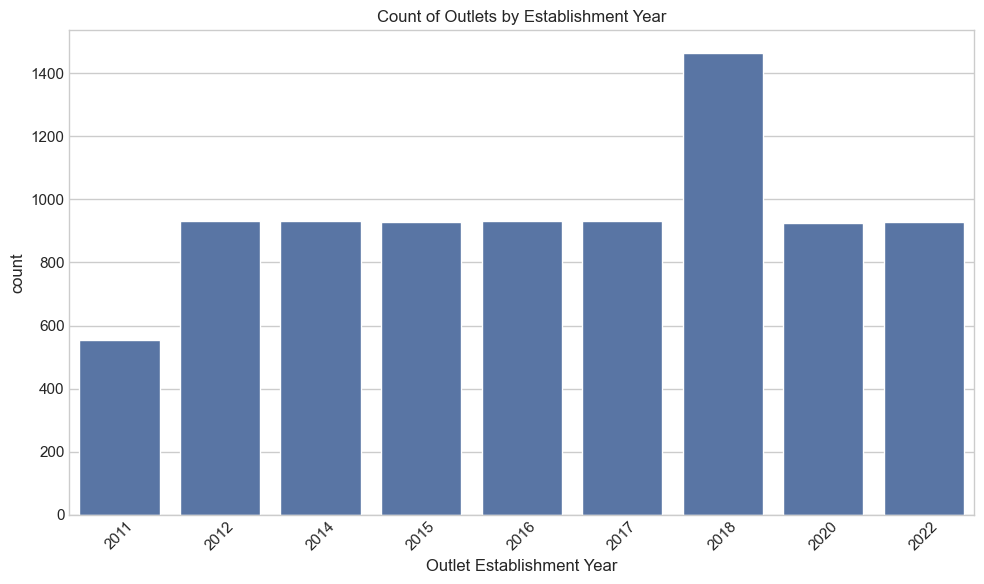

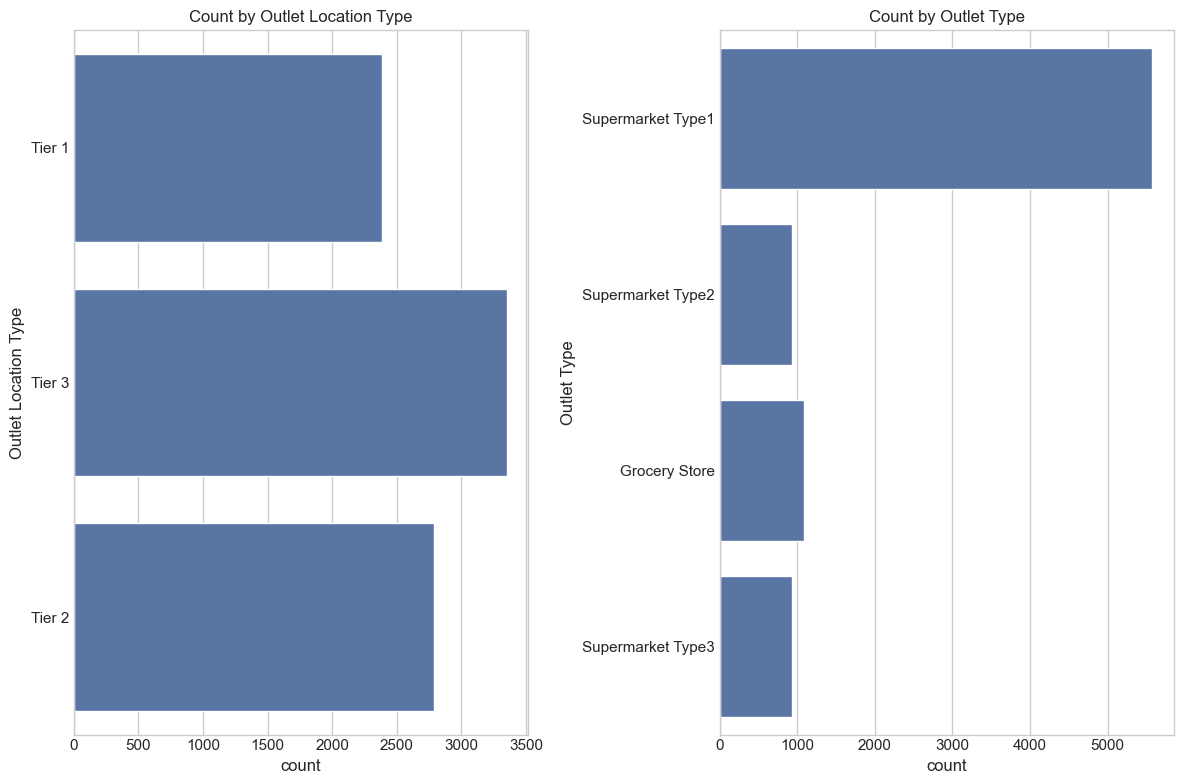


--- Bivariate Analysis ---


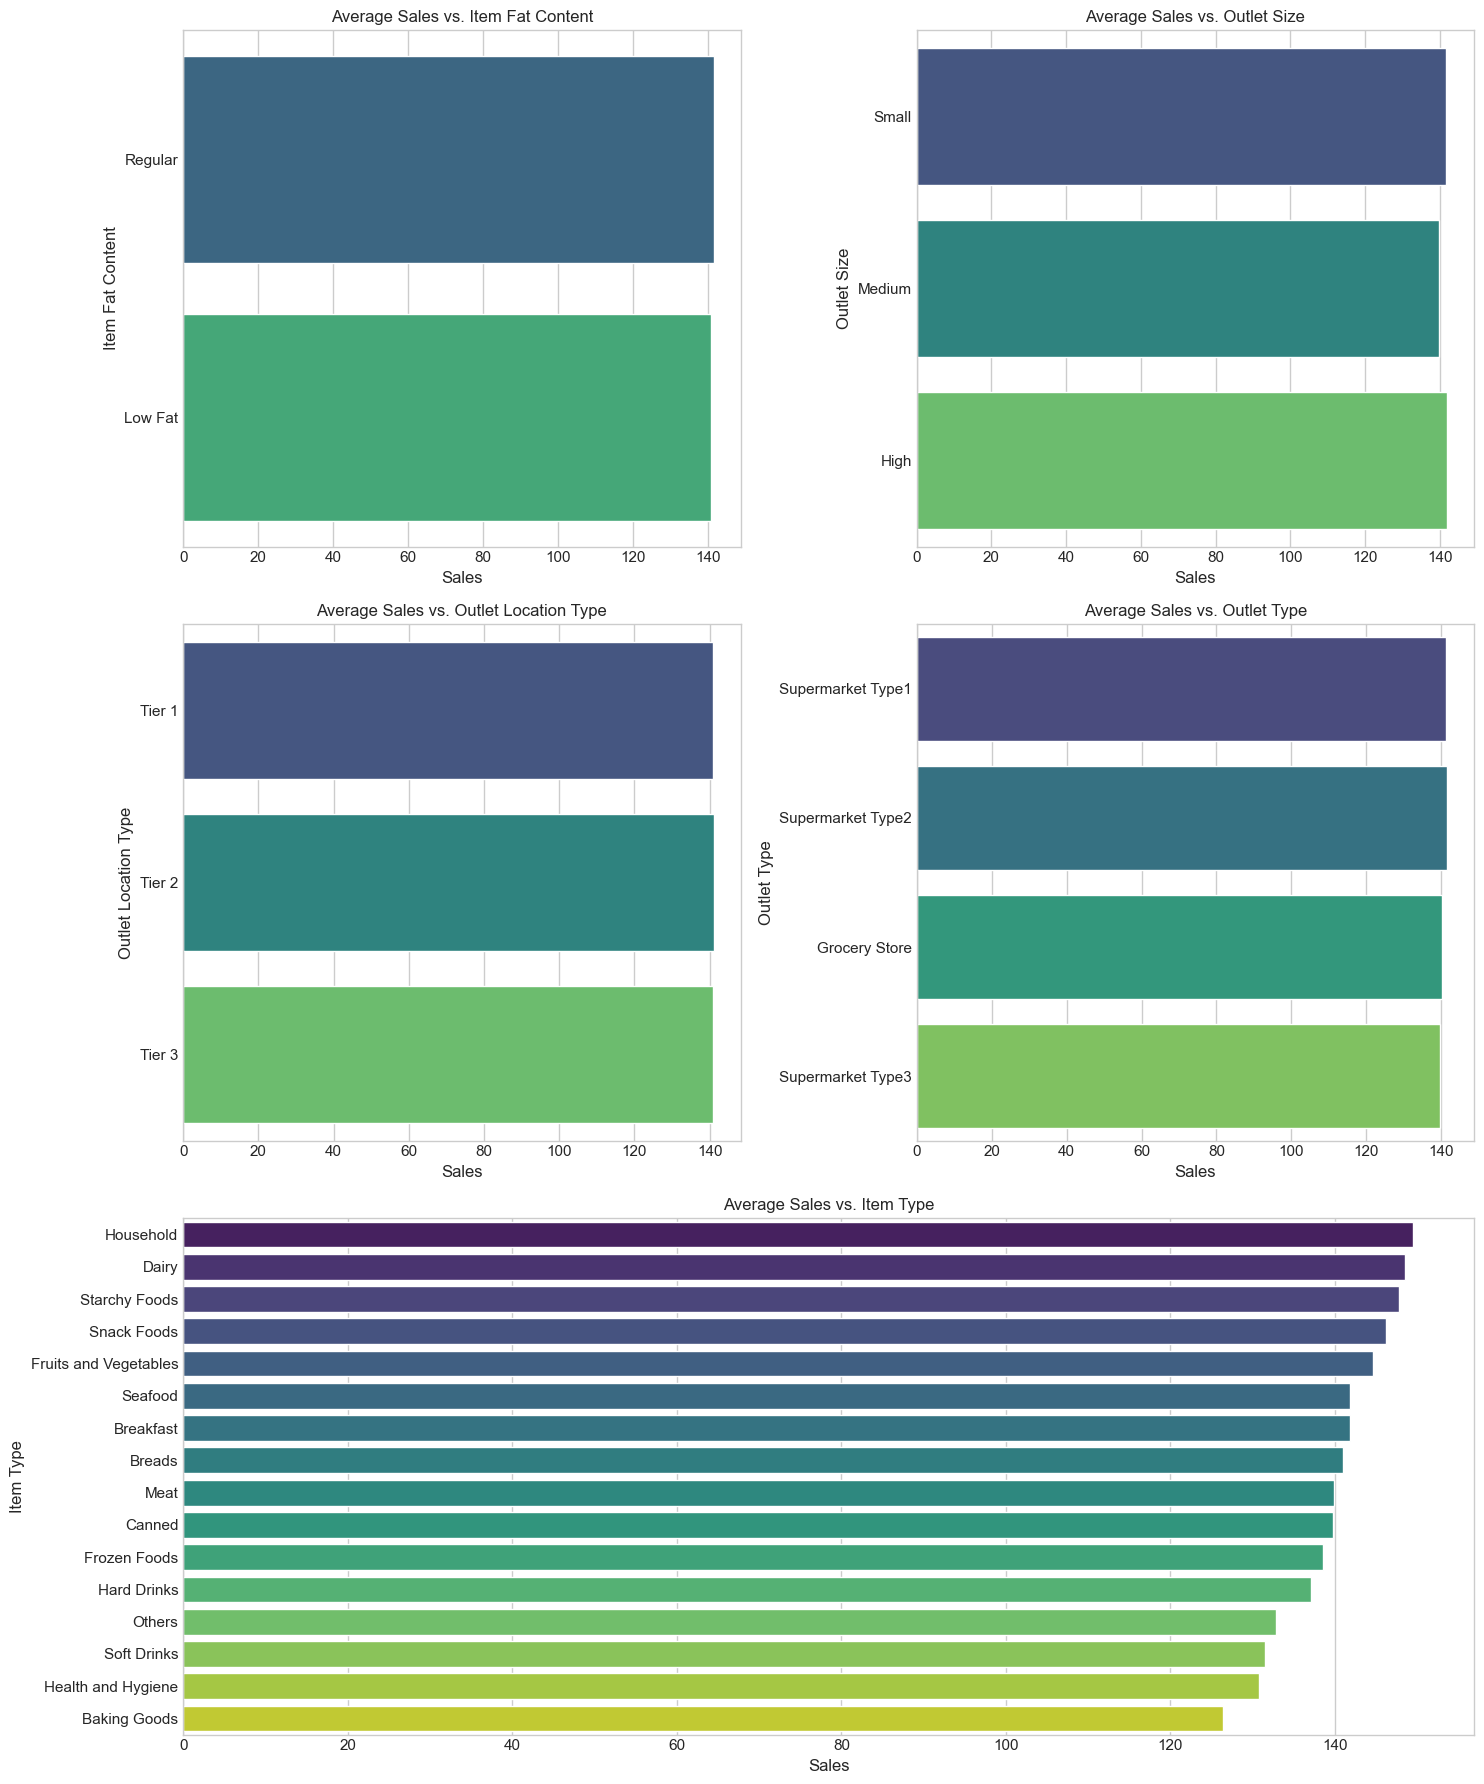

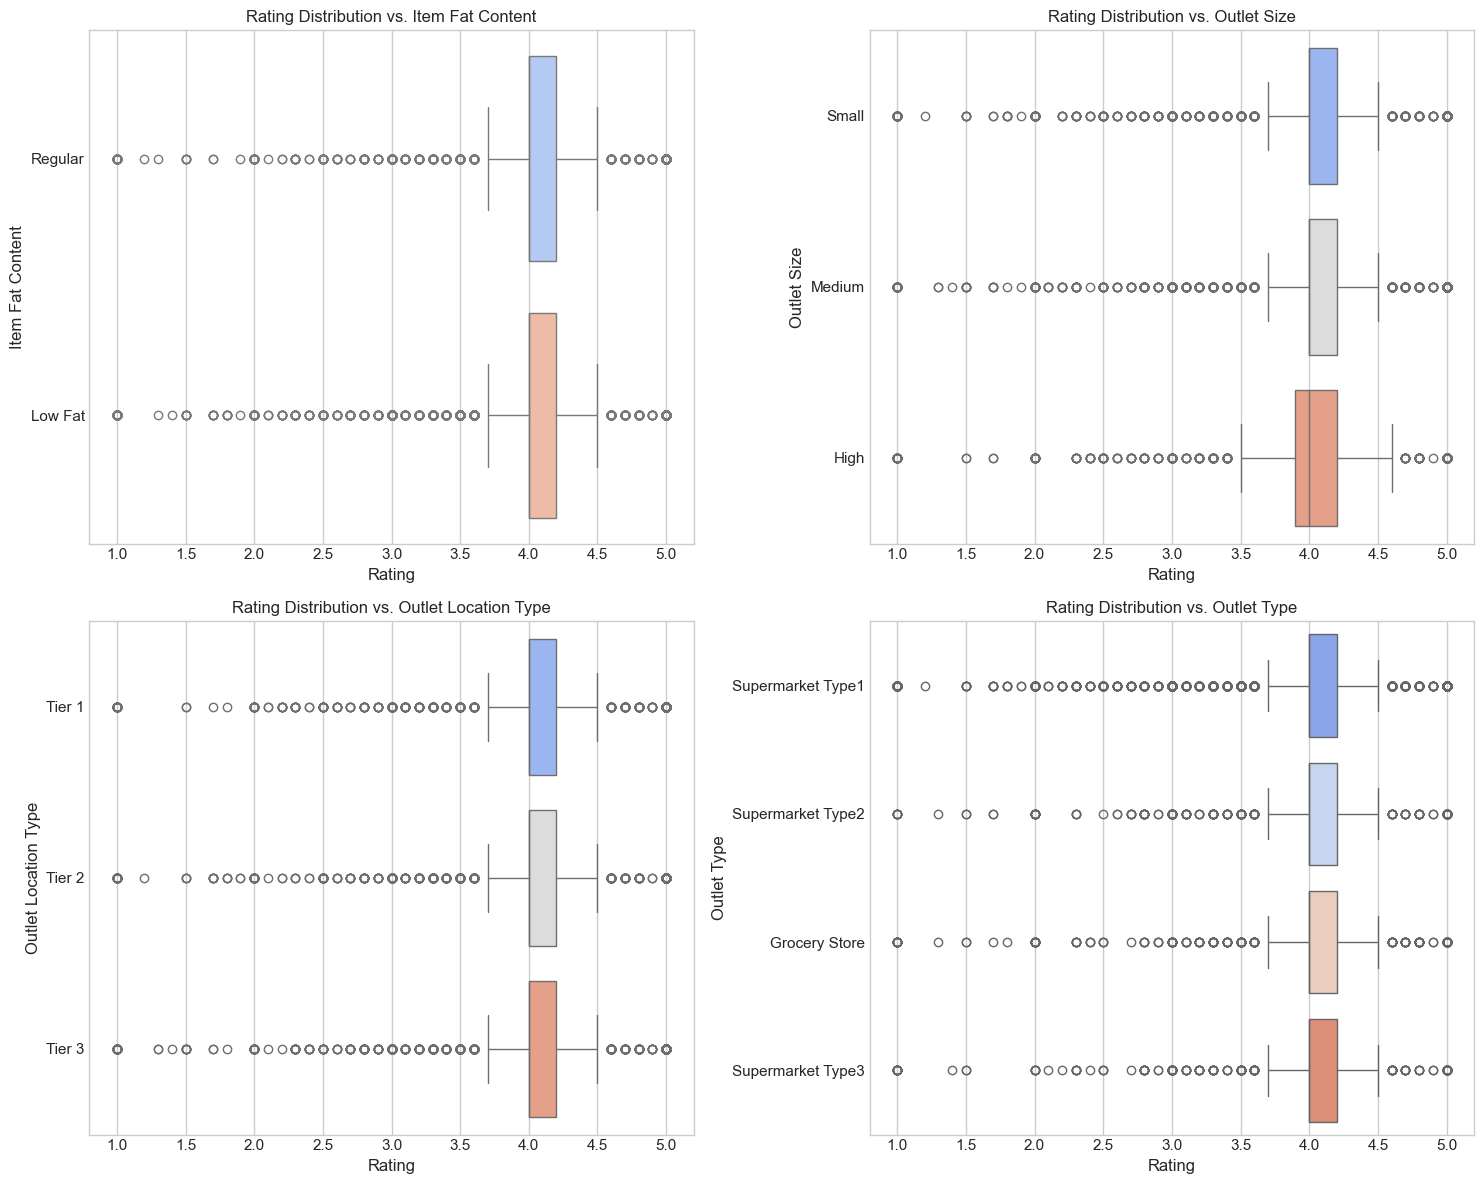

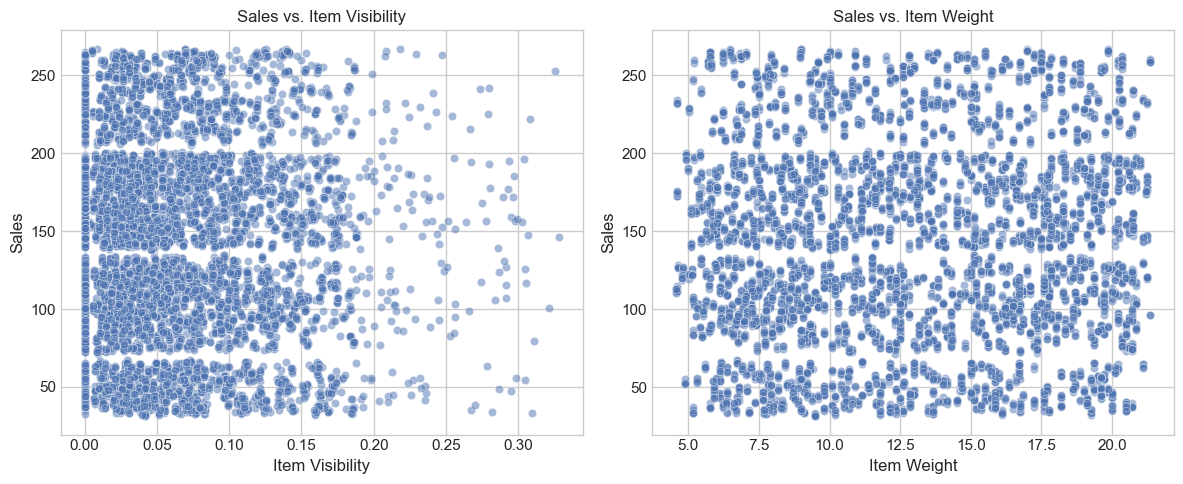

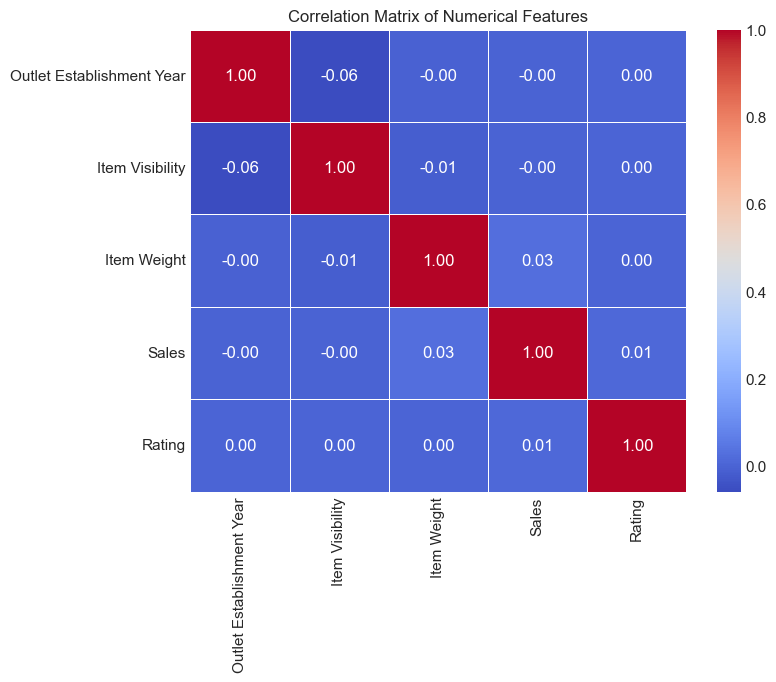


--- EDA Summary ---
*   Data consists of 8523 observations and 12 features.
*   Key features include item details (fat content, type, weight, visibility), outlet details (establishment year, size, location, type), sales, and ratings.
*   Data Cleaning: Standardized 'Item Fat Content' successfully. Acknowledged missing 'Item Weight' values.
*   Distribution Insights:
    - Sales is right-skewed, indicating most sales are lower, but there are high-value sales.
    - Item Visibility has many values near zero, potentially requiring investigation.
    - Ratings seem roughly normally distributed around the mean noted in Power BI (around 3.9).
    - Categorical counts align with Power BI observations (e.g., dominance of 'Low Fat', specific outlet types/sizes being more frequent).
*   Relationship Insights:
    - Average sales vary significantly by Item Type (Household, Fruits/Veggies high), Outlet Type (Supermarket Type1 high), Outlet Size (Medium highest), and Location Type (Tier 3 highest 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid') # Use a seaborn style

# --- 1. Load the Data ---
# Assume the Excel file is in the same directory or provide the full path
file_path = 'blinkit_grocery_data_orignal.xlsx' # <--- CHANGE THIS if your file name/path is different
try:
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit() # Exit if file not found

# --- 2. Initial Data Inspection ---
print("\n--- Initial Data Inspection ---")

print("\nFirst 5 Rows:")
print(df.head())

print("\nDataset Shape (Rows, Columns):")
print(df.shape)

print("\nColumn Names and Data Types:")
df.info()

print("\nSummary Statistics (Numerical Columns):")
# Round statistics for better readability
print(df.describe().round(2))

print("\nSummary Statistics (Categorical Columns):")
print(df.describe(include='object'))

# Check for potential leading/trailing spaces in column names
df.columns = df.columns.str.strip()
print("\nColumn Names (stripped):", df.columns.tolist())

# --- 3. Data Cleaning ---
print("\n--- Data Cleaning ---")

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Address Missing Values (Based on Transcript Insights)
# Item Weight: Has significant missing values. As per the Power BI approach,
# we won't impute for now, but acknowledge it.
# Outlet Size: Check if it has missing values (sometimes happens). If so, mode imputation is common.
if df['Outlet Size'].isnull().any():
    print(f"\nFound {df['Outlet Size'].isnull().sum()} missing values in Outlet Size.")
    # Example: Impute with mode (most frequent value)
    # outlet size_mode = df['Outlet Size'].mode()[0]
    # df['Outlet Size'].fillna(outlet size_mode, inplace=True)
    # print(f"Missing Outlet Size values imputed with mode ('{outlet size_mode}').")
    # For this exercise, we'll just report it if found, mirroring the video's scope.
else:
    print("\nNo missing values found in Outlet Size.")

# Standardize 'Item Fat Content' (Mirroring Power BI cleaning)
print("\nStandardizing 'Item Fat Content'...")
print("Original unique values:", df['Item Fat Content'].unique())
df['Item Fat Content'] = df['Item Fat Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})
print("Cleaned unique values:", df['Item Fat Content'].unique())
print("'Item Fat Content' standardized.")


# --- 4. Univariate Analysis (Analyzing Single Variables) ---
print("\n--- Univariate Analysis ---")

# Set figure size for plots
plt.figure(figsize=(18, 15)) # Adjust as needed

# Numerical Distributions
plt.subplot(3, 2, 1)
sns.histplot(df['Item Weight'].dropna(), kde=True, bins=30)
plt.title('Distribution of Item Weight')

plt.subplot(3, 2, 2)
sns.histplot(df['Item Visibility'], kde=True, bins=30)
plt.title('Distribution of Item Visibility')
# Note: Visibility often has values close to 0, which might need investigation in a real scenario.

plt.subplot(3, 2, 3)
sns.histplot(df['Sales'], kde=True, bins=50)
plt.title('Distribution of Sales')

plt.subplot(3, 2, 4)
sns.histplot(df['Rating'].dropna(), kde=True, bins=20)
plt.title('Distribution of Ratings')

# Categorical Distributions
plt.subplot(3, 2, 5)
sns.countplot(y=df['Item Fat Content'])
plt.title('Count of Items by Fat Content')

plt.subplot(3, 2, 6)
sns.countplot(y=df['Outlet Size'].fillna('Missing')) # Temporarily fillna for plotting count
plt.title('Count of Outlets by Size')


plt.tight_layout()
plt.show()


# Plotting distributions for high-cardinality categoricals separately
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Item Type'], order = df['Item Type'].value_counts().index)
plt.title('Count of Items by Type')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x=df['Outlet Establishment Year'], order=sorted(df['Outlet Establishment Year'].unique()))
plt.title('Count of Outlets by Establishment Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.countplot(y=df['Outlet Location Type'])
plt.title('Count by Outlet Location Type')

plt.subplot(1, 2, 2)
sns.countplot(y=df['Outlet Type'])
plt.title('Count by Outlet Type')

plt.tight_layout()
plt.show()

# --- 5. Bivariate Analysis (Analyzing Relationships Between Two Variables) ---
print("\n--- Bivariate Analysis ---")

# Sales vs. Categorical Variables
plt.figure(figsize=(15, 18))

plt.subplot(3, 2, 1)
sns.barplot(data=df, y='Item Fat Content', x='Sales', palette='viridis', ci=None)
plt.title('Average Sales vs. Item Fat Content')

plt.subplot(3, 2, 2)
sns.barplot(data=df, y='Outlet Size', x='Sales', order=['Small', 'Medium', 'High'], palette='viridis', ci=None)
plt.title('Average Sales vs. Outlet Size')

plt.subplot(3, 2, 3)
sns.barplot(data=df, y='Outlet Location Type', x='Sales', order=['Tier 1', 'Tier 2', 'Tier 3'], palette='viridis', ci=None)
plt.title('Average Sales vs. Outlet Location Type')

plt.subplot(3, 2, 4)
sns.barplot(data=df, y='Outlet Type', x='Sales', palette='viridis', ci=None)
plt.title('Average Sales vs. Outlet Type')

plt.subplot(3, 1, 3) # Span across bottom
sns.barplot(data=df, y='Item Type', x='Sales', palette='viridis', ci=None, order=df.groupby('Item Type')['Sales'].mean().sort_values(ascending=False).index)
plt.title('Average Sales vs. Item Type')


plt.tight_layout()
plt.show()


# Rating vs. Categorical Variables
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Rating', y='Item Fat Content', palette='coolwarm')
plt.title('Rating Distribution vs. Item Fat Content')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Rating', y='Outlet Size', order=['Small', 'Medium', 'High'], palette='coolwarm')
plt.title('Rating Distribution vs. Outlet Size')

plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Rating', y='Outlet Location Type', order=['Tier 1', 'Tier 2', 'Tier 3'], palette='coolwarm')
plt.title('Rating Distribution vs. Outlet Location Type')

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Rating', y='Outlet Type', palette='coolwarm')
plt.title('Rating Distribution vs. Outlet Type')

plt.tight_layout()
plt.show()


# Numerical vs. Numerical Relationships
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Item Visibility', y='Sales', alpha=0.5)
plt.title('Sales vs. Item Visibility')
# Note: Points with visibility 0 might be errors or specific cases (e.g., backroom items).

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Item Weight', y='Sales', alpha=0.5)
plt.title('Sales vs. Item Weight')

plt.tight_layout()
plt.show()


# Correlation Heatmap for numerical features
plt.figure(figsize=(8, 6))
# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# --- 6. Summary of EDA Findings ---
print("\n--- EDA Summary ---")
print("*   Data consists of 8523 observations and 12 features.")
print("*   Key features include item details (fat content, type, weight, visibility), outlet details (establishment year, size, location, type), sales, and ratings.")
print("*   Data Cleaning: Standardized 'Item Fat Content' successfully. Acknowledged missing 'Item Weight' values.")
print("*   Distribution Insights:")
print("    - Sales is right-skewed, indicating most sales are lower, but there are high-value sales.")
print("    - Item Visibility has many values near zero, potentially requiring investigation.")
print("    - Ratings seem roughly normally distributed around the mean noted in Power BI (around 3.9).")
print("    - Categorical counts align with Power BI observations (e.g., dominance of 'Low Fat', specific outlet types/sizes being more frequent).")
print("*   Relationship Insights:")
print("    - Average sales vary significantly by Item Type (Household, Fruits/Veggies high), Outlet Type (Supermarket Type1 high), Outlet Size (Medium highest), and Location Type (Tier 3 highest average).")
print("    - Rating distributions show subtle differences across categories but generally hover around the overall average.")
print("    - Item Visibility shows a weak (or complex non-linear) relationship with Sales. The cluster near zero visibility is interesting.")
print("    - Item Weight shows no strong linear correlation with Sales.")
print("    - The correlation matrix confirms weak linear relationships between most numerical features, except possibly a slight positive correlation between Sales and Weight/Visibility (though scatter plots suggest complexity).")
print("\nEDA complete. These insights align with the Power BI dashboard requirements and provide a foundation for the visualized analysis.")

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
file_path = 'blinkit_grocery_data_orignal.xlsx' # <--- Make sure this path is correct
try:
    # When reading, pandas handles spaces in column names automatically
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully.")
    # Strip any leading/trailing whitespace from column names just in case
    df.columns = df.columns.str.strip()
    print("Original column names:", df.columns.tolist())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit()

# Rename 'Item Outlet Sales' for clarity if it exists (based on transcript)
if 'Item Outlet Sales' in df.columns:
    df.rename(columns={'Item Outlet Sales': 'Sales'}, inplace=True)
    print("Renamed 'Item Outlet Sales' to 'Sales'")

# Verify the target variable 'Sales' exists
if 'Sales' not in df.columns:
    print("Error: Target column 'Sales' not found in the dataset.")
    exit()

# --- 2. Basic Cleaning & Feature Engineering ---
print("\n--- Cleaning Data ---")

# Standardize 'Item Fat Content'
print("Original 'Item Fat Content' values:", df['Item Fat Content'].unique())
df['Item Fat Content'] = df['Item Fat Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})
print("Cleaned 'Item Fat Content' values:", df['Item Fat Content'].unique())

# Feature Engineering: Extract Outlet Age
current_year = pd.Timestamp.now().year
if 'Outlet Establishment Year' in df.columns:
    df['Outlet Age'] = current_year - df['Outlet Establishment Year']
    print("'Outlet Age' feature created.")
else:
    print("Warning: 'Outlet Establishment Year' not found, cannot create 'Outlet Age'.")


# --- 3. Feature Selection ---
# Drop identifiers and the original year column
# 'Item Identifier' and 'Outlet Identifier' usually don't help predict sales directly
# and have too many unique values (high cardinality) for simple encoding.
features_to_drop = ['Item Identifier', 'Outlet Identifier']
# Only drop Outlet Establishment Year if Outlet Age was created
if 'Outlet Age' in df.columns:
    features_to_drop.append('Outlet Establishment Year')

# Check which columns actually exist before dropping
existing_cols_to_drop = [col for col in features_to_drop if col in df.columns]
df.drop(columns=existing_cols_to_drop, inplace=True)
print(f"Dropped columns: {existing_cols_to_drop}")

# Define target and features
TARGET = 'Sales'
FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

print(f"\nPredicting '{TARGET}' using features: {FEATURES}")

# --- 4. Preprocessing ---
print("\n--- Setting up Preprocessing ---")

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Check if 'Outlet Size' is categorical and handle its order if needed
if 'Outlet Size' in categorical_features:
    print("'Outlet Size' identified as categorical.")
    # Note: If treating as ordinal, you might use OrdinalEncoder separately
    # For simplicity here, we'll use OneHotEncoder which works for nominal/ordinal.

print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

# Create preprocessing pipelines for numerical and categorical features

# Numerical Pipeline:
# 1. Impute missing values (e.g., 'Item Weight', 'Rating') with the median
# 2. Scale features to have zero mean and unit variance
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline:
# 1. Impute missing values (e.g., 'Outlet Size') with a constant value like 'Missing' or the mode
# 2. One-Hot Encode categorical variables
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Or strategy='constant', fill_value='Missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # handle_unknown ignores categories only seen in test data
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough' # Keep any columns not specified (shouldn't be any here)
)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into Train ({X_train.shape[0]} samples) and Test ({X_test.shape[0]} samples)")

# --- 6. Model Training ---
# We'll try two models: Linear Regression and RandomForestRegressor

# --- Model 1: Linear Regression ---
print("\n--- Training Linear Regression ---")
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
print("Linear Regression training complete.")

# --- Model 2: Random Forest Regressor ---
print("\n--- Training Random Forest Regressor ---")
# For Random Forest, scaling is less critical, but the pipeline structure is convenient
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # n_estimators=100 is a common default, n_jobs=-1 uses all available CPU cores
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=10, min_samples_leaf=5)) # Added some hyperparameters
])

rf_pipeline.fit(X_train, y_train)
print("Random Forest training complete.")


# --- 7. Evaluation ---
print("\n--- Model Evaluation ---")

models = {'Linear Regression': lr_pipeline, 'Random Forest': rf_pipeline}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    print(f"\n{name}:")
    print(f"  R-squared (R2): {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- Summary ---
print("\n--- Evaluation Summary ---")
results_df = pd.DataFrame(results).T # Transpose for better viewing
print(results_df.round(4))

best_r2_model = results_df['R2'].idxmax()
print(f"\nModel with the best R-squared score on the test set: {best_r2_model}")

lr_model_filename = 'linear_regression_sales_model.joblib'
rf_model_filename = 'random_forest_sales_model.joblib'

# Save the Linear Regression pipeline (preprocessor + model)
try:
    joblib.dump(lr_pipeline, lr_model_filename)
    print(f"Linear Regression model pipeline saved successfully to '{lr_model_filename}'")
except Exception as e:
    print(f"Error saving Linear Regression model: {e}")

# Save the Random Forest pipeline (preprocessor + model)
try:
    joblib.dump(rf_pipeline, rf_model_filename)
    print(f"Random Forest model pipeline saved successfully to '{rf_model_filename}'")
except Exception as e:
    print(f"Error saving Random Forest model: {e}")


Dataset loaded successfully.
Original column names: ['Item Fat Content', 'Item Identifier', 'Item Type', 'Outlet Establishment Year', 'Outlet Identifier', 'Outlet Location Type', 'Outlet Size', 'Outlet Type', 'Item Visibility', 'Item Weight', 'Sales', 'Rating']

--- Cleaning Data ---
Original 'Item Fat Content' values: ['Regular' 'Low Fat' 'low fat' 'LF' 'reg']
Cleaned 'Item Fat Content' values: ['Regular' 'Low Fat']
'Outlet Age' feature created.
Dropped columns: ['Item Identifier', 'Outlet Identifier', 'Outlet Establishment Year']

Predicting 'Sales' using features: ['Item Fat Content', 'Item Type', 'Outlet Location Type', 'Outlet Size', 'Outlet Type', 'Item Visibility', 'Item Weight', 'Rating', 'Outlet Age']

--- Setting up Preprocessing ---
'Outlet Size' identified as categorical.
Categorical Features: ['Item Fat Content', 'Item Type', 'Outlet Location Type', 'Outlet Size', 'Outlet Type']
Numerical Features: ['Item Visibility', 'Item Weight', 'Rating', 'Outlet Age']

Data split into